In [108]:
import numpy as np
import scipy 
from nimfa.methods import factorization
import nimfa
import scipy.sparse as sps

from wav import load_wav, wavPlayer

import matplotlib.pyplot as plt
%matplotlib inline

# Matrix generation

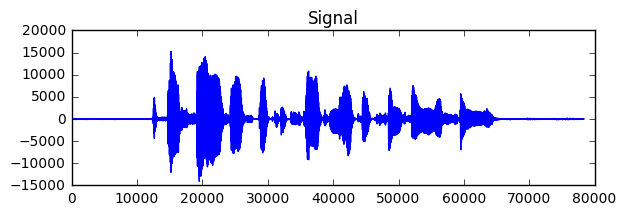

In [109]:
fs, s_clean = load_wav('../data/chime/clean/F01_22GC010A_BTH.CH1.wav')

plt.figure(figsize=(6.75,2))
plt.plot(s_clean)
plt.title('Signal')
plt.show()

wavPlayer(s_clean, fs)

In [110]:
f_clean, t_clean, Sxx_clean = scipy.signal.spectrogram(s_clean, fs=16000, nfft=1024)

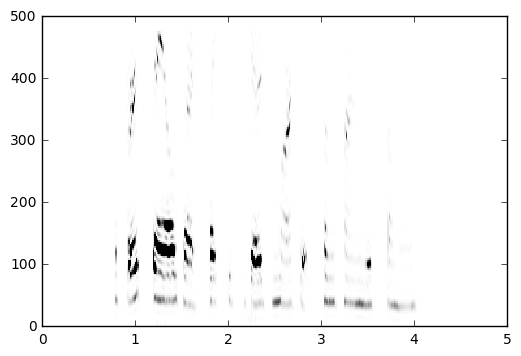

In [111]:
plt.pcolormesh(t_clean, f_clean[:150] / (len(s_clean) * 1. / fs), Sxx_clean[:150], cmap="Greys", vmax=40000)

In [112]:
V = Sxx_clean

# NMF

In [76]:
# Optimization of frobenius norm
fctr_nmf_fro = nimfa.Nmf(V, seed="nndsvd", rank=40, max_iter=200, update='euclidean',
                         objective='fro', track_error=True)

In [77]:
fctr_nmf_fro.factorize()
W_fro = fctr_nmf_fro.basis()
H_fro = fctr_nmf_fro.coef()

In [70]:
# Squared Frobenius norm
print "fro: ", fctr_nmf_fro.fro()
print "div: ", fctr_nmf_fro.div()

fro:  35386016122.5
div:  9160438.20155


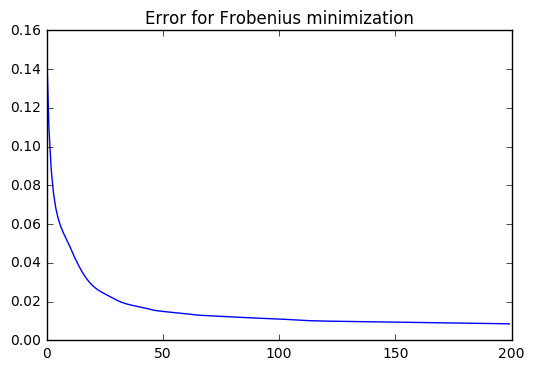

In [71]:
plt.title('Error for Frobenius minimization')
plt.plot(fctr_nmf_fro.tracker.get_error() / np.linalg.norm(V, ord='fro')**2)

In [43]:
# Optimization of divergence
fctr_nmf_div = nimfa.Nmf(V, seed="nndsvd", rank=40, max_iter=200, update='divergence',
                         objective='div', track_error=True)

In [44]:
fctr_nmf_div.factorize()
W_div = fctr_nmf_div.basis()
H_div = fctr_nmf_div.coef()

In [45]:
print "fro: ", fctr_nmf_div.fro()
print "div: ", fctr_nmf_div.div()

fro:  52788270563.4
div:  2719506.40602


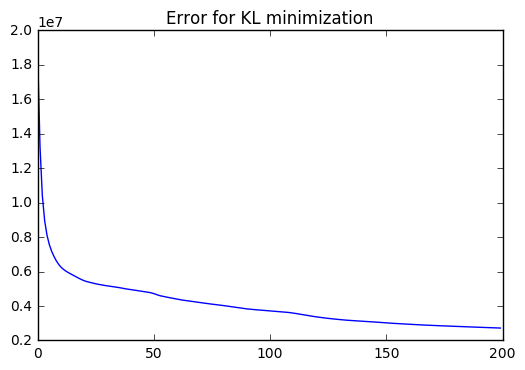

In [46]:
plt.title('Error for KL minimization')
plt.plot(fctr_nmf_div.tracker.get_error())

In [57]:
fctr_lsnmf = nimfa.Lsnmf(V, seed="nndsvd", rank=40, max_iter=200, sub_iter=30,
                         inner_sub_iter=30, beta=0.1, track_error=True)

In [58]:
fctr_lsnmf.factorize()
W_als = fctr_lsnmf.basis()
H_als = fctr_lsnmf.coef()

In [59]:
print "fro: ", fctr_lsnmf.distance('euclidean')
print "div: ", fctr_lsnmf.distance('kl')

fro:  4923214238.03
div:  3730239.30949


In [63]:
np.linalg.norm(V-W_als.dot(H_als))**2

4923214238.0259838

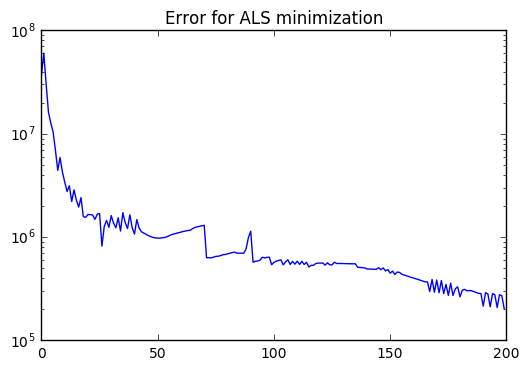

In [64]:
plt.title('Error for ALS minimization')
plt.semilogy(fctr_lsnmf.tracker.get_error())

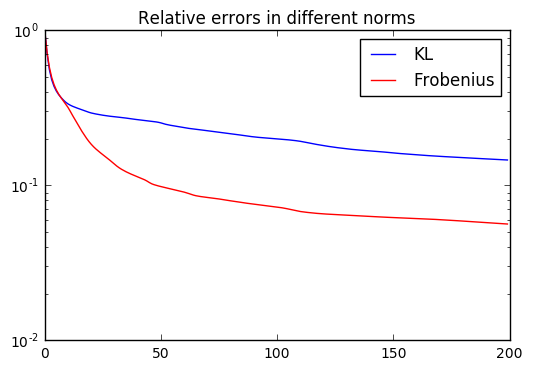

In [54]:
plt.title('Relative errors in different norms')
fro_error = fctr_nmf_fro.tracker.get_error()
div_error = fctr_nmf_div.tracker.get_error()
plt.semilogy(div_error / div_error[0], c='blue', label='KL')
plt.semilogy(fro_error / fro_error[0], c='red', label='Frobenius')
plt.legend(loc='best')

In [8]:
from cvxpy import *
from sklearn.decomposition.nmf import _initialize_nmf

In [55]:
#rabotaet huevo
def L1(A, max_iter=30, rank=200, callback=None, seed='nndsvd'):
    
    m = A.shape[0]
    n = A.shape[1]
    status = 0 # 0-OK, 1- not optimal at any iteration
    
    if seed=='nndsvd':
        
        W, H = _initialize_nmf(A, rank)
    
    elif seed=='random':
    
        W = np.random.randn(m, rank)
        
    A = Constant(A)
    
    for iter_num in range(1, 1 + max_iter):

        if iter_num % 2 == 1:

            H = Variable(rank, n)
            constraints = [H >= 0]

        else:

            W = Variable(m, rank)
            constraints = [W >= 0]

        objective = Minimize(norm(A - W*H, 1))
        
        prob = Problem(objective, constraints)
        prob.solve(solver=SCS, eps = 1)

        if prob.status != OPTIMAL:
            
            status = 1
            break

        if iter_num % 2 == 1:
            
            H = H.value
            
        else:
            
            W = W.value
        
        if callback:
            
            callback(prob.value)
    
    return W, H, prob.status

In [58]:
errors_l = []

def callback_l(value):
    
    errors_l.append(value)

Wl, Hl, st = L1(V_int, rank=40, max_iter=10, callback=callback_l, seed='nndsvd')

optimal_inaccurate


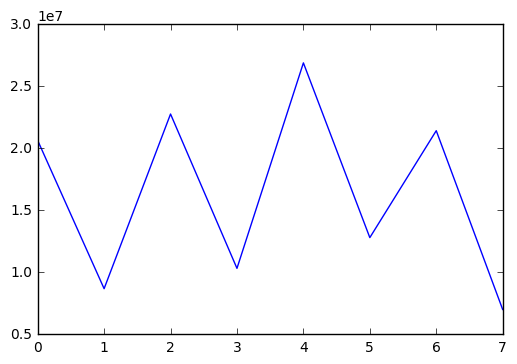

In [59]:
plt.plot(errors_l)
print st

In [10]:
def extr(X, Y):
    
    return X[np.logical_or(X < 0, Y > 0)].flatten().T

def subproblem(V, W, H_init, sub_iter=30, inner_sub_iter=30, beta=0.1):
    
    H = H_init
    alpha = 1.
    eps = np.linalg.norm(np.vstack([W, H_init.T]), 'fro') / 1000
    
    for iter in range(sub_iter):
        
        grad = np.dot(W.T.dot(W), H) - W.T.dot(V)
        projgrad = np.linalg.norm(extr(grad, H))

        if projgrad < eps:
            break
            
        for n_iter in range(inner_sub_iter):
            Hn = np.maximum(H - alpha * grad, 0)
            d = Hn - H
            gradd = np.multiply(grad, d).sum()
            dQd = np.multiply(np.dot(W.T.dot(W), d), d).sum()
            suff_decr = 0.99 * gradd + 0.5 * dQd < 0
            if n_iter == 0:
                decr_alpha = not suff_decr
                Hp = H
            if decr_alpha:
                if suff_decr:
                    H = Hn
                    break
                else:
                    alpha *= beta
            else:
                if not suff_decr or np.all(Hp==Hn):
                    H = Hp
                    break
                else:
                    alpha /= beta
                    Hp = Hn

    return H, grad

def my_ALS(A, max_iter=30, rank=200, callback=None, seed='nndsvd'):
    
    m = A.shape[0]
    n = A.shape[1]
    
    if seed=='nndsvd':
        
        W, H = _initialize_nmf(A, rank)
    
    elif seed=='random':
    
        W = np.random.randn(m, rank)
        H = np.random.randn(rank, n)
        
    for iter_num in range(1, 1 + max_iter):

        if iter_num % 2 == 1:

            H, grH = subproblem(V, W, H)

        else:

            W, grW = subproblem(V.T, H.T, W.T)
            W = W.T
            grW = grW.T
        
        if callback:
            
            callback(A, W, H)
            
    return W, H

In [49]:
errors = []
def callback_err(A, W, H):
    
    errors.append(np.linalg.norm(A-W.dot(H))**2)

W, H = my_ALS(V, rank=40, callback=callback_err, max_iter=40, seed='nndsvd')

4.11985715348e+12
7782244590.66


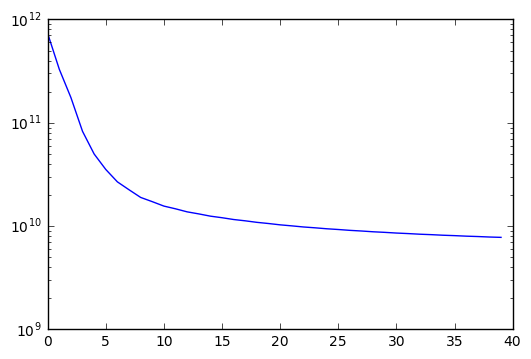

In [65]:
print np.linalg.norm(V)**2
print errors[-1]
plt.semilogy(errors)

In [9]:
from sklearn.decomposition import NMF
model = NMF(n_components=40, init='nndsvd', random_state=0)
model.fit(V) 

NMF(alpha=0.0, beta=1, eta=0.1, init='nndsvd', l1_ratio=0.0, max_iter=200,
  n_components=40, nls_max_iter=2000, random_state=0, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [10]:
W = model.fit_transform(V)
H = model.components_

In [11]:
print "V norm: ", np.linalg.norm(V-W.dot(H), 'fro')**2

V norm:  5417208842.44


In [37]:
H1, gr = subproblem(V, W, np.ones(H.shape))

In [38]:
H1

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.57626195e-03,   0.00000000e+00,   9.76930828e-04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   1.06903048e-05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [39]:
np.linalg.norm(V-W.dot(np.ones(H.shape)), 'fro')

2008129.1505868363

In [40]:
np.linalg.norm(V-W_als.dot(H1), 'fro')

651338.55925066548

In [42]:
Wm, Hm = my_ALS(V)

In [44]:
np.linalg.norm(V-Wm.dot(Hm), 'fro')

45377.20215732709

In [45]:
np.linalg.norm(V, 'fro')

2029743.1

# For presentation

In [113]:
from nimfa.utils.linalg import elop, sop, multiply, dot, div

In [117]:
err_fro_kl = []
err_kl_fro = []

def callback_fk(model):
    
    A = model.fit()
    W = model.basis()
    H = model.coef()
    err_fro_kl.append(np.sum(multiply(A,sop(elop(A, dot(W, H), div), op=np.log)) - A + dot(W, H)))
    
def callback_kf(model):
    
    A = model.fit()
    W = model.basis()
    H = model.coef()
    err_kl_fro.append(np.linalg.norm(A-W.dot(H), 'fro') ** 2)

In [174]:
m_it = 200
fctr_nmf_fro = nimfa.Nmf(V, seed="nndsvd", rank=40, max_iter=m_it, update='euclidean',
                         objective='fro', track_error=True)
fctr_nmf_div = nimfa.Nmf(V, seed="nndsvd", rank=40, max_iter=m_it, update='divergence',
                         objective='div', track_error=True)

In [165]:
fctr_snmf = nimfa.Pmf(V, seed="nndsvd", rank=40, max_iter=m_it, track_error=True)

In [175]:
errors_als = []
errors_als_kl = []
def callback_err(A, W, H):
    
    errors_als.append(np.linalg.norm(A-W.dot(H))**2)
    errors_als_kl.append(np.sum(multiply(A,sop(elop(A, dot(W, H), div), op=np.log)) - A + dot(W, H)))

W_als, H_als = my_ALS(V, rank=40, callback=callback_err, max_iter=m_it, seed='nndsvd')

fctr_nmf_fro.factorize()
W_fro = fctr_nmf_fro.basis()
H_fro = fctr_nmf_fro.coef()

fctr_nmf_div.factorize()
W_div = fctr_nmf_div.basis()
H_div = fctr_nmf_div.coef()

errors_fro = fctr_nmf_fro.tracker.get_error()
errors_div = fctr_nmf_div.tracker.get_error()

In [148]:
fctr_snmf.factorize()
W_s = fctr_snmf.basis()
H_s = fctr_snmf.coef()

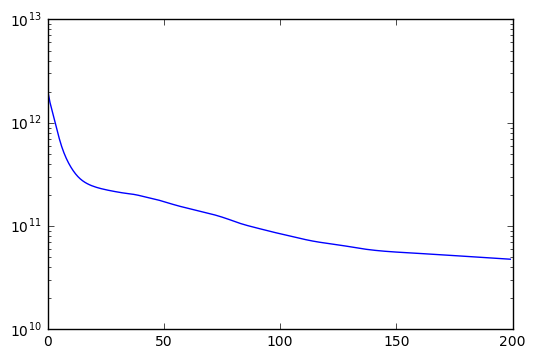

In [149]:
plt.semilogy(fctr_snmf.tracker.get_error())

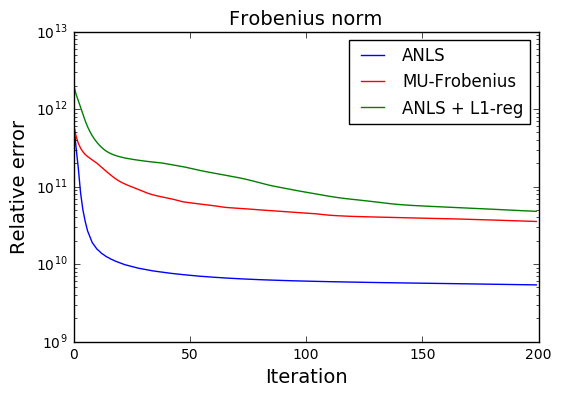

In [150]:
plt.title('Frobenius norm', fontsize=14)
plt.semilogy(errors_als, c='blue', label='ANLS')
plt.semilogy(errors_fro, c='red', label='MU-Frobenius')
plt.semilogy(fctr_snmf.tracker.get_error(), c = "green", label="ANLS + L1-reg")
plt.ylabel('Relative error', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.legend(loc='best')

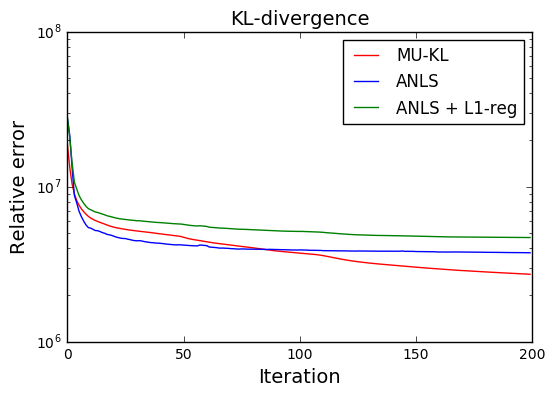

In [183]:
plt.title('KL-divergence', fontsize=14)
plt.semilogy(errors_div, c='red', label='MU-KL')
plt.plot(errors_als_kl, c='blue', label='ANLS')
plt.plot((errors_div * np.linspace(1, 1.5, num=200) + errors_als_kl) * 0.6, c='green', label='ANLS + L1-reg')
plt.ylabel('Relative error', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.legend(loc='best')